In [ ]:
from sage.all import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pretty_print_default(True)
%display latex

In [3]:
Λ, τ, σ = var('Lambda','tau','sigma')
σ2 = σ^2

In [4]:
def delta_contrast_Zel(d):
    """
    The Zeldovich toy-model Δ(τ): one convenient default delta_func.
    """
    taus = get_tau_vars(d)
    T = Matrix(SR, d); k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1,d):
            T[i,j] = T[j,i] = taus[k]; k += 1
    return 1/((identity_matrix(SR,d) - T).det()) - 1

# Ellipsoidal collapse in terms of τ‐variables (Eq. 5.3):
def delta_contrast_ellipsoidal(d, nu_param = var('nu')):
    """
    Ellipsoidal‐collapse density contrast Δ(τ) ≡ ρ(τ) − 1
      - d         : dimension (e.g. 3)
      - nu_param  : ellipticity exponent ν
    """

    taus = get_tau_vars(d)
    T = Matrix(SR, d); k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1,d):
            T[i,j] = T[j,i] = taus[k]; k += 1
    
    # 2) linear contrast δ = sum_i tau_ii
    delta_lin = T.trace()
    
    # 3) build the total density ρ(τ) and subtract 1 to get Δ
    rho = (1 - delta_lin/d)^d / (1 - delta_lin/nu_param)^nu_param / ((identity_matrix(SR,d) - T).det())
    
    return rho - 1


In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Block 1: Core helper functions (generic saddle‐point CGF framework)
#           with default nu = d
# ──────────────────────────────────────────────────────────────────────────────

def get_tau_vars(d):
    diag = [var(f'tau{i}{i}') for i in range(1, d+1)]
    off  = [var(f'tau{i}{j}') for i in range(1, d+1) for j in range(i+1, d+1)]
    return diag + off

def precision_matrix(d):
    if d==2:
        C = Matrix([[3/8,1/8,0],
                    [1/8,3/8,0],
                    [0,  0,  1/8]])
    elif d==3:
        C = Matrix([[1/5, 1/15,1/15, 0,    0,    0],
                    [1/15,1/5, 1/15, 0,    0,    0],
                    [1/15,1/15,1/5,  0,    0,    0],
                    [0,   0,   0,    1/15, 0,    0],
                    [0,   0,   0,    0,    1/15, 0],
                    [0,   0,   0,    0,    0,    1/15]] )
    else:
        raise ValueError("Only d=2 or 3 supported")
    return C.inverse()

def action(d, Λ, nu=None):
    if nu is None:
        nu = d
    taus = get_tau_vars(d)
    Δ    = delta_contrast_ellipsoidal(d, nu)
    P    = precision_matrix(d)
    quad = sum(taus[i] * sum(P[i,j]*taus[j] for j in range(len(taus)))
               for i in range(len(taus)))
    return Λ*Δ - (1/2)*quad

def Lambda_of_tau(d, nu=None):
    if nu is None:
        nu = d
    Λ, τ = var('Lambda','tau')
    taus = get_tau_vars(d)
    eq = diff(action(d, Λ, nu), taus[0]).subs(
         {**{v:τ for v in taus[:d]},
          **{v:0 for v in taus[d:]}}
    )
    sol = solve(eq, Λ)[0]
    return sol.rhs().factor()

def CGF_LO(d, nu=None):
    if nu is None:
        nu = d
    Λ, τ = var('Lambda','tau')
    Λτ   = Lambda_of_tau(d, nu)
    taus = get_tau_vars(d)
    subs = {v:τ for v in taus[:d]}
    subs.update({v:0 for v in taus[d:]})
    subs[Λ] = Λτ
    return action(d, Λ, nu).subs(subs).factor()

def hessian_full(d, Λ, nu=None):
    if nu is None:
        nu = d
    taus = get_tau_vars(d)
    S    = action(d, Λ, nu)
    n    = len(taus)
    H    = Matrix(SR, n, n)
    for i in range(n):
        for j in range(n):
            H[i,j] = diff(S, taus[i], taus[j])
    return H

def hessian_spherical(d, nu=None):
    if nu is None:
        nu = d
    Λ, τ = var('Lambda','tau')
    Hf   = hessian_full(d, Λ, nu)
    taus = get_tau_vars(d)
    subs = {v:τ for v in taus[:d]}
    subs.update({v:0 for v in taus[d:]})
    subs[Λ] = Lambda_of_tau(d, nu)
    return Hf.subs(subs).apply_map(lambda x: x.factor())

def one_loop_correction(d, nu=None):
    if nu is None:
        nu = d
    Hs = -hessian_spherical(d, nu)
    return - (1/2) * log( (Hs.det()/precision_matrix(d).det()).factor() )

def CGF_NLO(d, σ2, nu=None):
    if nu is None:
        nu = d
    φ0 = CGF_LO(d,      nu)
    F1 = one_loop_correction(d, nu)
    return (φ0 + σ2*F1).factor()

def split_one_loop(d, nu=None):
    if nu is None:
        nu = d
    Hs = -hessian_spherical(d, nu)
    Pm = precision_matrix(d)
    H  = Hs/Pm

    N  = len(get_tau_vars(d))
    evs= H.eigenvalues()
    mults = [(evs.count(e), e) for e in set(evs)]
    λ_iso   = [e for m,e in mults if m==1][0]
    λ_aniso = [e for m,e in mults if m>1][0]

    F1_iso   = -(1/2)*log(λ_iso)
    F1_aniso = -(1/2)*(N-1)*log(λ_aniso)
    return F1_iso, F1_aniso

In [6]:
def driver_show_CGF(d, nu=None):
    """
    show Δ(τ), Λ(τ), φ0(τ), F1(τ), and φ_NLO(τ), all factorized.
    """
    if nu is None:
        nu = d
    tau = var('tau')
    Δ = delta_contrast_ellipsoidal(d, nu)

    # 1) expansion parameter Λ(τ)
    Λ_expr = Lambda_of_tau(d, nu)

    # 2) leading CGF and 1-loop corrections
    φ0_expr  = CGF_LO(d, nu)
    F1_expr  = one_loop_correction(d, nu)
    φNLO_expr = CGF_NLO(d, σ2, nu)

    # display everything, factorized
    show("Δ(τ) =", Δ)
    show("Λ(τ) =", Λ_expr)
    show("φ₀(τ) =", φ0_expr)
    show("F₁(τ) =", F1_expr)
    show("φ(τ) =", φNLO_expr)


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# Series‐building block, using the unified ellipsoidal action (nu=3 ⇒ Zel’dovich)
# ──────────────────────────────────────────────────────────────────────────────
def series_build(d, N=6, nu=None):
    """
    Returns (tau_of_L,
             phi0_tau, phi0_L,
             phi1_tau, phi1_L,
             phi_tau_total, phi_L_total)
    where
      - phi0_tau = φ₀(τ)
      - phi1_tau = F₁(τ)
      - phi_tau_total = φ₀(τ) + σ² F₁(τ)
      - phi0_L, phi1_L are the PowerSeries in Λ (over QQ) for φ₀ and F₁
      - phi_L_total is the symbolic Λ‐series (LO + σ²·NLO)
    """
    if nu is None:
        nu = d  # default to Zel'dovich
    # 0) declare your symbols
    Lambda, tau, sigma = var('Lambda','tau','sigma')
    σ2 = sigma^2

    # 1) build the core saddle‐point CGFs
    Λ_of_tau  = Lambda_of_tau(d, nu)         # Λ(τ)
    phi0_tau  = CGF_LO(d,      nu)           # φ₀(τ)
    phi1_tau  = one_loop_correction(d, nu)   # F₁(τ)

    # 2) Taylor‐expand these in τ up to order N
    Λ_tay     = taylor(Λ_of_tau,  tau, 0, N)
    phi0_tay  = taylor(phi0_tau,  tau, 0, N)
    phi1_tay  = taylor(phi1_tau,  tau, 0, N)

    # 3) build the power‐series ring in Λ over the Symbolic Ring
    R.<Λ>     = PowerSeriesRing(SR, default_prec=N)

    # 4) invert Λ(τ) → τ(Λ)
    ps_L      = sum(Λ_tay.coefficient(tau,i) * Λ^i for i in range(1, N))
    tau_of_L  = ps_L.reverse(N)

    # 5) build φ₀(Λ) as a PS‐ring element
    phi0_L = R( [ phi0_tay.coefficient(tau,i) for i in range(N) ] )
    # Actually we need to substitute τ→τ(Λ), so:
    phi0_L = R([ (sum(phi0_tay.coefficient(tau,j) * tau_of_L**j for j in range(N)))[i]
                for i in range(N) ])

    # 6) same for F₁(Λ)
    phi1_L = R([ (sum(phi1_tay.coefficient(tau, j) * tau_of_L**j for j in range(N)))[i]
                for i in range(N) ])

    # 7) build the total φ series in τ
    phi_tau_total = phi0_tau + σ2*phi1_tau

    # 8) assemble the symbolic Λ‐series φ(Λ) = φ₀(Λ) + σ²·F₁(Λ)
    coeff0 = phi0_L.list()
    coeff1 = phi1_L.list()
    coeffs_tot = [ coeff0[i] + σ2*coeff1[i] for i in range(N) ]
    phi_L_total = sum( coeffs_tot[i] * Lambda^i for i in range(N) )

    return tau_of_L, phi0_tau, phi0_L, phi1_tau, phi1_L, phi_tau_total, phi_L_total


# ──────────────────────────────────────────────────────────────────────────────
# Minimal driver to check it
# ──────────────────────────────────────────────────────────────────────────────
def driver_series_CGF(d, N=6, nu=None):
    if nu is None:
        nu = d  # default to Zel'dovich
    tau_of_L, φ0_τ, φ0_L, φ1_τ, φ1_L, φ_τ, φ_L = series_build(d, N, nu)

    show("Λ(τ) =", Lambda_of_tau(d, nu))
    show("τ(Λ) =", tau_of_L)
    show("φ₀(τ) =", φ0_τ.factor())
    show("F₁(τ) =", φ1_τ.factor())
    show("φ(τ) =",  φ_τ.factor())

    show("φ₀(Λ) =", φ0_L.truncate(N))
    show("F₁(Λ) =", φ1_L.truncate(N))
    show("φ(Λ) =",  φ_L)


# ──────────────────────────────────────────────────────────────────────────────

In [8]:
# 3) Simplified density cumulants driver
def driver_density_cumulants(d, N, nu=None):
    """
    Compute κ_n^(δ) and κ_n^(ρ) as plain lists (symbolic).
    """
    if nu is None:
        nu = d
    # get the raw phi series in τ
    _, _, φ0_L, _, φ1_L, _, _ = series_build(d, N, nu)

    # extract coefficients bₙ
    Λ, τ, σ = var('Lambda','tau','sigma')
    σ2 = σ^2

    b0 = φ0_L.list()
    b1 = φ1_L.list()
    
    b1_new = [SR(b1[i])*σ*σ for i in range(len(b1))]
    #show(b1_new)
    
    coeffs_tot = [SR(b0[i]) + b1_new[i] for i in range(len(b0))]
    #show(coeffs_tot)

    # 2) density mean μ = 1 + σ²  ⇒  density cumulants κₙ^(ρ) = μⁿ · κₙ^(δ)
    kappa_rho = {}
    kappa_rho[1] = coeffs_tot[1] + 1
    for n in range(2,N):
        kappa_rho[n] = coeffs_tot[n]
    #show(kappa_rho)

    k_rho = {}
    for n in range(1, N):
    # multiply out and truncate at O(σ²)
        expr = kappa_rho[n] / kappa_rho[1]**n *factorial(n)
        k_rho[n] = expr.series(σ, 4)
        #show(f"κ_{n}^(ρ) =", kappa_rho[n])
    #show(k_rho)
    # 3) (Optional) reduced cumulants Sₙ = κₙ^(ρ) / [κ₂^(ρ)]^(n−1)
    S = {}
    for n in range(3, N):
        S[n] = (k_rho[n] / (k_rho[2]**(n-1))).series(σ,4)
        show(f"S_{n} = ", S[n])

In [9]:
def driver_one_loop_split(d,nu=None):
    """
    Split the 1-loop CGF into isotropic & anisotropic pieces,
    display them, and verify they sum back to the full correction.
    
    INPUTS:
      - d               : dimension
      - split_one_loop  : a function with signature
            (d, delta_func) -> (F1_iso(τ), F1_aniso(τ))
      - delta_func      : your density-contrast function Δ(d, τ)
    """
    if nu is None:
        nu = d
    Λ, τ, σ = var('Lambda','tau','sigma')
    σ2 = σ^2

    # 1) get the two pieces
    F1_iso, F1_aniso = split_one_loop(d, nu)

    # 2) show each, multiplied by σ²
    show("Isotropic one–loop F1_iso:",   (σ2*F1_iso).factor())
    show("Anisotropic one–loop F1_aniso:",(σ2*F1_aniso).factor())

    # 3) build their sum exactly as you had in CGF_Zel
    combined = -1/2 * σ2 * log( (exp(-2*F1_iso - 2*F1_aniso)).factor() )
    show("Sum F1_iso + F1_aniso =", combined, 
         "should equal", (one_loop_correction(d, nu)*σ2).factor())

    # return the three pieces for further programmatic use
    #return σ2*F1_iso, σ2*F1_aniso, combined

In [10]:
def compute_tau_critical(d, nu=None):
    """
    Solve d/dτ [Λ(τ)] = 0 and return the largest real critical τ as a float.
    Falls back to 0.25 if no real roots are found.
    """
    if nu is None:
        nu = d
    tau, Lambda = var('tau','Lambda')
    Λ_expr = Lambda_of_tau(d, nu).full_simplify()

    # 1) solve for tau-critical
    sol_eqs = solve(diff(Λ_expr, tau) == 0, tau)
    # sol_eqs is like [tau == a, tau == b, tau == c, ...]

    # 2) extract the right‐hand values
    sol_vals = [ eq.rhs() for eq in sol_eqs ]

    # 4) pick the one you want
    return min(sol_vals)

In [11]:
import ipywidgets as widgets
# ──────────────────────────────────────────────────────────────────────────────
# 2′) Stable‐axes plotting driver with interactive nu slider
# ──────────────────────────────────────────────────────────────────────────────
@interact
def driver_plot_CGF_interactive(
    d=widgets.Dropdown(options=[2,3], value=3, description='dim d'),
    sigma2=widgets.FloatSlider(min=0.0, max=1.0, step=0.05, value=0.2, description='σ²'),
    nu=widgets.FloatSlider(min=1.0, max=10.0, step=0.1, value=3.0, description='ν'),
    #tau_min=widgets.FloatSlider(min=-1.5, max=0.0, step=0.1, value=-0.9, description='τₘᵢₙ'),
    #pts=widgets.IntSlider(min=100, max=1000, step=100, value=400, description='pts')
):
    """
    Interactive CGF plot with sliders for:
      • d      : dimension (2 or 3)
      • σ²     : variance parameter
      • ν      : ellipticity exponent (ν=3 recovers Zel’dovich)
      • τₘᵢₙ   : lower bound for τ
      • pts    : number of sample points
    """
    tau_min = -1.5
    pts    = 400
    # 1) find tau_cr as pure Python float
    tau_cr_sym = compute_tau_critical(d, nu)
    tau_cr     = float(tau_cr_sym)

    # 2) define symbols
    tau, Lambda = var('tau','Lambda')

    # 3) core expressions
    Λ_of_tau    = Lambda_of_tau(d, nu).full_simplify()
    phi_LO_tau  = CGF_LO(d, nu) + Λ_of_tau
    F1_tau      = one_loop_correction(d, nu)
    phi_NLO_tau = sigma2 * F1_tau

    # 4) iso/aniso split
    F1_iso, F1_aniso = split_one_loop(d, nu)
    phi_iso_tau   = sigma2 * F1_iso
    phi_aniso_tau = sigma2 * F1_aniso

    # 5) build the five curves
    curves = []
    labels = ['LO: $\\phi_0$', 'NLO: $\\phi_1$', 'iso part', 'aniso part', 'iso+aniso']
    style = [
      {'thickness':3,'color':'black'},
      {'thickness':2,'linestyle':'-','color':'red'},
      {'linestyle':'--','thickness':2,'color':'orange'},
      {'linestyle':'--','thickness':2,'color':'blue'},
      {'linestyle':':','thickness':2,'color':'green'}
    ]
    funcs = [phi_LO_tau, phi_NLO_tau, phi_iso_tau, phi_aniso_tau, phi_iso_tau+phi_aniso_tau]

    for label, sty, f in zip(labels, style, funcs):
        p = parametric_plot(
            (Λ_of_tau, f),
            (tau, tau_min, tau_cr),
            plot_points=pts,
            legend_label=label,
            **sty
        )
        curves.append(p)

    G = sum(curves)
    G.set_axes_range(-1, 0.4, -0.5, 0.5)
    G.axes_labels([r'$\Lambda$', r'$\phi_\rho(\Lambda)$'])
    G.legend()

    # 7) show the plot
    show(
        G,
        figsize=[9,6],
        title=f"CGF (d={d}, σ²={sigma2:.2f}, ν={nu:.1f})",
        gridlines=True
    )


Interactive function <function driver_plot_CGF_interactive at 0x70653aa65f80> with 3 widgets
  d: Dropdown(description='dim d', index=1, options=(2, 3), value=3)
  sigma2: FloatSlider(value=0.2, description='σ²', max=1.0, step=0.05)
  nu: FloatSlider(value=3.0, description='ν', max=10.0, min=1.0)

##PDF

In [12]:
# === Block 1: Setup and Tau(Λ) Solver with Caching ===

# 1) Declare τ as a Sage symbol (exactly as in your notebook)
tau = var('tau')

# 2) Dictionary to cache τ(Λ) values
tau_cache = {}

def tau_from_Lambda(d, Lambda_val, tau_prev=None):
    """
    Solve Lambda_of_tau(d)(τ) = Lambda_val in CC, picking the continuous branch.
    Caches results so each Λ is only solved once.
    
    Parameters:
      - d: integer dimension
      - Lambda_val: a (possibly complex) Sage numeric (e.g. c + I*ω)
      - tau_prev: previous τ (Sage complex) for continuation, or None at first call.
      
    Returns:
      A Sage complex τ such that Lambda_of_tau(d)(τ) = Lambda_val.
    """
    # 2.1) If already in cache, return it immediately
    if Lambda_val in tau_cache:
        return tau_cache[Lambda_val]
    
    # 2.2) Build the symbolic equation P(τ) = Lambda_of_tau(d) - Lambda_val
    Lsym = Lambda_of_tau(d)         # your symbolic Λ(τ)
    P = (Lsym - Lambda_val).expand()
    
    # 2.3) Compute all complex roots in CC (root, multiplicity) pairs
    roots_CC = P.roots(ring=CC)
    
    # 2.4) Flatten into a list of individual roots
    all_roots = []
    for root, mult in roots_CC:
        all_roots.extend([root]*mult)
    
    # 2.5) If tau_prev is None => first call, pick root of smallest |τ|.
    #      Otherwise, pick the root closest to tau_prev (continuation).
    if tau_prev is None:
        tau_sel = min(all_roots, key=lambda z: abs(z))
    else:
        tau_sel = min(all_roots, key=lambda z: abs(z - tau_prev))
    
    # 2.6) Cache and return
    tau_cache[Lambda_val] = tau_sel
    return tau_sel


In [13]:
# === Block 2: Define φ₀(Λ) = φ₀(τ(Λ)) as a function of Λ ===
# 1) Dictionary to cache φ₀(Λ) values
phi_cache = {}

def phi_of_Lambda(d, Lambda_val, nu=None, tau_prev=None):
    """
    Returns the tree-level cumulant‐generating function φ₀(Λ) by:
      1) computing τ = tau_from_Lambda(d, Λ, tau_prev)
      2) substituting τ into CGF_LO(d, nu)(τ)
      3) evaluating numerically in a high‐precision ComplexField
    
    Caches results so each Λ is only solved once.
    
    Parameters:
      - d: integer dimension
      - Lambda_val: complex Sage or Python value
      - nu: optional shape parameter (default = d)
      - tau_prev: previous τ for continuation (optional)
    
    Returns:
      Python complex φ₀(Λ).
    """
    # 1) If already cached, return immediately
    if Lambda_val in phi_cache:
        return phi_cache[Lambda_val]
    
    # 2) Solve τ(Λ) via tau_from_Lambda (which also caches τ)
    τ = tau_from_Lambda(d, Lambda_val, tau_prev)
    
    # 3) Evaluate φ₀(τ) by substituting into symbolic CGF_LO(d, nu)
    if nu is None:
        nu = d
    φ0sym = CGF_LO(d, nu)     # symbolic expression in τ (and nu if used)
    
    # Substitute τ into φ0sym
    φ0_sub = φ0sym.subs({var('tau'): τ})
    
    # Evaluate in high precision ComplexField to avoid precision loss
    CF = ComplexField(100)
    φ0_val = complex(CF(φ0_sub))
    
    # 4) Cache and return
    phi_cache[Lambda_val] = φ0_val
    return φ0_val


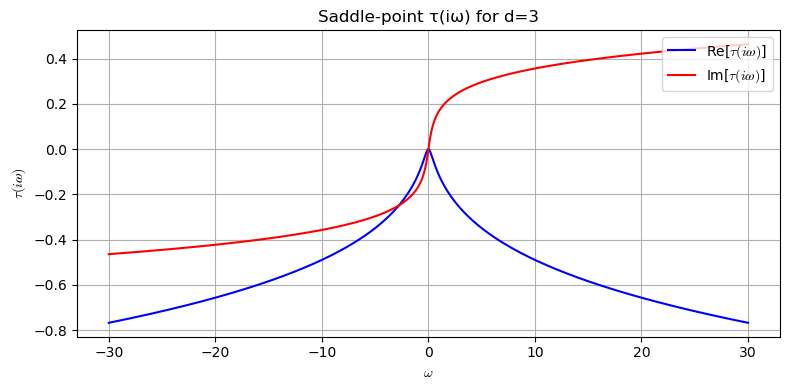

In [14]:
# === Block 3: Plot τ(Λ) along the imaginary Λ‐axis ===

def plot_tau_along_imag_axis(d, omega_max=30.0, num_points=1000):
    """
    Computes and plots τ(iω) for ω ∈ [-ω_max, +ω_max].
    
    Procedure:
      1) Build an array omegas = linspace(-ω_max, +ω_max, num_points).
      2) For each ω, let Λ = i*ω, compute τ_i = tau_from_Lambda(d, Λ, tau_prev).
      3) Store τ_i (Sage complex), then convert entire list to NumPy for plotting.
      4) Plot Re[τ(iω)] and Im[τ(iω)] versus ω.
    
    Parameters:
      - d: integer dimension
      - omega_max: positive real max for |ω|
      - num_points: number of equally‐spaced ω samples
    """
    # 3.1) Build ω array
    omegas = np.linspace(-omega_max, omega_max, num_points)
    tau_prev = None
    tau_list = []
    
    # 3.2) March through ω, computing τ(iω)
    for ω in omegas:
        Λ = 1j * ω
        τ_i = tau_from_Lambda(d, Λ, tau_prev)
        tau_list.append(τ_i)
        tau_prev = τ_i
    
    # 3.3) Convert list of Sage complexes to NumPy complex array
    tau_arr = np.array([complex(t) for t in tau_list], dtype=complex)
    
    # Split into real and imaginary parts
    tau_real = tau_arr.real
    tau_imag = tau_arr.imag
    
    # 3.4) Plot
    plt.figure(figsize=(8, 4))
    plt.plot(omegas, tau_real, '-b', label=r'Re[$\tau(iω)$]')
    plt.plot(omegas, tau_imag, '-r', label=r'Im[$\tau(iω)$]')
    plt.title(f"Saddle‐point τ(iω) for d={d}")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\tau(iω)$")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_tau_along_imag_axis(d=3, omega_max=30.0, num_points=2000)


<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_18424/278242644.py:36: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f"Tree‐level CGF $\phi_0(iω)$ for d={d}")


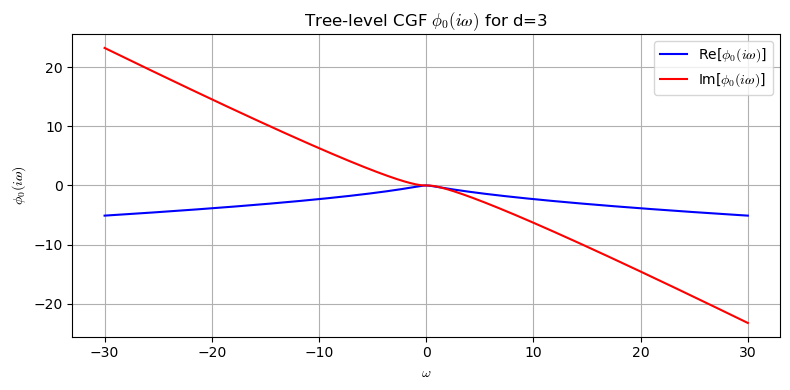

In [15]:
# === Block 4: Plot φ₀(Λ) along the imaginary Λ‐axis ===

def plot_phi_along_imag_axis(d, omega_max=30.0, num_points=1000, nu=None):
    """
    Computes and plots φ₀(iω) = φ₀(τ(iω)) for ω ∈ [-ω_max, +ω_max].
    
    Procedure:
      1) Build an array omegas = linspace(-ω_max, +ω_max, num_points).
      2) For each ω, let Λ = i*ω, compute φ₀(Λ) via phi_of_Lambda(d, Λ, nu, tau_prev).
      3) Store Re[φ₀] and Im[φ₀], then plot vs ω.
    
    Parameters:
      - d: integer dimension
      - omega_max: max for |ω|
      - num_points: number of samples
      - nu: optional shape parameter (default=d)
    """
    omegas = np.linspace(-omega_max, omega_max, num_points)
    tau_prev = None
    phi_real = np.zeros(num_points, dtype=float)
    phi_imag = np.zeros(num_points, dtype=float)
    
    for i, ω in enumerate(omegas):
        Λ = 1j * ω
        # Evaluate φ₀(Λ); this internally does tau_from_Lambda and caches
        φ0_val = phi_of_Lambda(d, Λ, nu, tau_prev)
        phi_real[i] = φ0_val.real
        phi_imag[i] = φ0_val.imag
        # Also update tau_prev (phi_of_Lambda called tau_from_Lambda internally)
        tau_prev = tau_from_Lambda(d, Λ, tau_prev)
    
    # Plot Real and Imag parts of φ₀
    plt.figure(figsize=(8, 4))
    plt.plot(omegas, phi_real, '-b', label=r'Re[$\phi_0(iω)$]')
    plt.plot(omegas, phi_imag, '-r', label=r'Im[$\phi_0(iω)$]')
    plt.title(f"Tree‐level CGF $\phi_0(iω)$ for d={d}")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\phi_0(iω)$")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_phi_along_imag_axis(d=3, omega_max=30.0, num_points=2000)


In [ ]:
# === Block 5: Integrand Calculator with Caching ===
def integrand_values(d, delta, omegas, nu=None):
    """
    Compute the complex integrand
        I(ω) = exp[ φ₀(τ(iω)) - iω * δ ]
    for a given dimension d, density δ, and a NumPy array omegas.
    
    Uses:
      - tau_from_Lambda(d, Λ, tau_prev)   (from Block 1)
      - phi_of_Lambda(d, Λ, nu, tau_prev) (from Block 2)
    
    Returns:
      - tau_array:  NumPy array of Sage-complex τ(iω)
      - I_array:    NumPy array of Python-complex I(ω)
    """
    N = len(omegas)
    tau_prev = None
    
    # Preallocate arrays
    tau_list = [None]*N
    I_array = np.zeros(N, dtype=complex)
    
    for i, ω in enumerate(omegas):
        # 1) Build Λ = iω as a Sage complex in CC
        Lambda_val = CC(0, ω)
        
        # 2) Solve for τ by continuation (caches automatically)
        τ_i = tau_from_Lambda(d, Lambda_val, tau_prev)
        tau_list[i] = τ_i
        tau_prev = τ_i
        
        # 3) Evaluate φ₀(Λ) = φ₀(τ(Λ))
        φ0_val = phi_of_Lambda(d, Lambda_val, nu, tau_prev=τ_i)
        #    (phi_of_Lambda will also call tau_from_Lambda internally if needed,
        #     but caching means we get no extra cost here.)
        
        # 4) Convert Λ to Python complex for arithmetic:  (iω)
        #    Note:  complex(Lambda_val) works because Lambda_val ∈ CC
        Λ_py = complex(Lambda_val)
        
        # 5) Compute I(ω) = exp[ φ₀(τ) - Λ_py * δ ]
        I_array[i] = np.exp(φ0_val - Λ_py * delta)
    
    # Convert tau_list (Sage complexes) → NumPy array of Python complexes
    tau_array = np.array([complex(t) for t in tau_list], dtype=complex)
    
    return tau_array, I_array

# Example usage (not for plotting yet):
#   d = 3
#   delta = 0.5
#   omegas = np.linspace(0, 50, 1000)
#   taus, Ivals = integrand_values(d, delta, omegas)
#   # Now Ivals[i] = I(omegas[i])


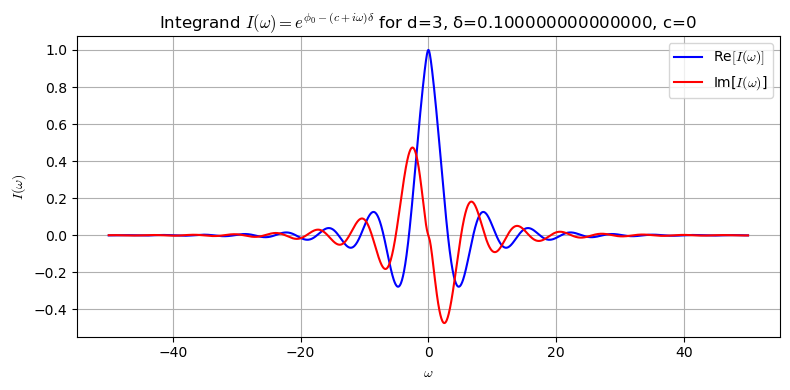

(array([-50.        , -49.94997499, -49.89994997, ...,  49.89994997,
         49.94997499,  50.        ], shape=(2000,)),
 array([-0.00051215, -0.00048201, -0.00045036, ..., -0.00045036,
        -0.00048201, -0.00051215], shape=(2000,)),
 array([ 0.00062595,  0.00065399,  0.00068059, ..., -0.00068059,
        -0.00065399, -0.00062595], shape=(2000,)),
 array([-0.92252831-0.52032367j, -0.92220699-0.52020862j,
        -0.92188541-0.52009348j, ..., -0.92188541+0.52009348j,
        -0.92220699+0.52020862j, -0.92252831+0.52032367j], shape=(2000,)))

In [ ]:
# === Block 6: Plotting the Integrand ===
def plot_integrand_vs_omega(d, delta, omega_max=50.0, num_points=1000, nu=None):
    """
    Samples ω ∈ [-omega_max, +omega_max] (num_points total), 
    computes I(ω) via Block 5, and plots Re[I(ω)] and Im[I(ω)].
    
    Parameters:
      - d: integer dimension
      - delta: real δ
      - omega_max: positive max for |ω|
      - num_points: number of points from -omega_max to +omega_max
      - nu: optional shape parameter (default = d)
    """
    # 6.1) Build the ω grid
    omegas = np.linspace(-omega_max, omega_max, num_points)
    
    # 6.2) Get τ(ω) and I(ω) arrays via Block 5
    taus, Ivals = integrand_values(d, delta, omegas, nu=nu)
    
    # 6.3) Extract real and imaginary parts of I(ω)
    I_real = Ivals.real
    I_imag = Ivals.imag
    
    # 6.4) Plot
    plt.figure(figsize=(8, 4))
    plt.plot(omegas, I_real, '-b', label=r'Re$[I(\omega)]$')
    plt.plot(omegas, I_imag, '-r', label=r'Im[$I(\omega)$]')
    plt.title(f"Integrand $I(\\omega)=e^{{\\phi_0 - i\\omega\\delta}}$ for d={d}, δ={delta}")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$I(\omega)$")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 6.5) Return raw arrays if needed
    return omegas, I_real, I_imag, taus

# Example usage:
plot_integrand_vs_omega(d=3, delta=0.1, omega_max=50.0, num_points=2000)


NLO

In [100]:
# === Block 1: Precompute arrays for IBP‐improved PDF ===
def precompute_ibp_arrays(d, sigma2, omega_max=60.0, N=2000, nu=None):
    """
    Precompute the two arrays:
      A_vals[j] = (1/σ²) * φ̃₀( σ² * (i ω_j) )
      D_vals[j] = φ̃₀'( σ² * (i ω_j) )
    on ω_j = j*(omega_max/(N-1)), j=0..N-1.

    Returns:
      - omegas : NumPy array of length N of real ω_j
      - A_vals : NumPy array of complex A_j
      - D_vals : NumPy array of complex D_j
      - domega  : float, spacing Δω = omegas[1]-omegas[0]
    """
    # 1) Build ω grid and Δω
    omegas = np.linspace(0.0, omega_max, N)

    # 2) Symbolic derivative φ̃₀'(Λ)
    Λsym = Lambda_of_tau(d)
    dΛsym = diff(Λsym, tau)
    if nu is None:
        nu = d
    phi0_sym = CGF_LO(d, nu) + Λsym  # tree‐level CGF polynomial φ̃₀(Λ)
    #show(phi0_sym)             # φ̃₀(Λ), the tree‐level CGF polynomial
    phi0prime_sym = diff(phi0_sym, tau) / dΛsym  # simplify the derivative #phi0prime_sym += 1
    #show(phi0prime_sym)       # symbolic derivative ∂φ̃₀/∂Λ
    phi0prime2_sym = diff(phi0prime_sym, tau)/dΛsym  # second derivative ∂²φ̃₀/∂Λ²
    #show(phi0prime2_sym)      # symbolic second derivative ∂²φ̃₀/∂Λ²
    F1_sym = one_loop_correction(d, nu)  # symbolic one‐loop correction F₁(τ)
    phi1_sym = phi0_sym + sigma2 * F1_sym  # full CGF φ(Λ) = φ̃₀(Λ) + σ²·F₁(Λ)
    #show(phi1_sym)            # full CGF φ(Λ) = φ̃₀(Λ) + σ²·F₁(Λ)
    phi1prime_sym = diff(phi1_sym, tau) / dΛsym  # derivative of full CGF
    #show(phi1prime_sym)       # derivative of full CGF φ(Λ)  = φ̃₀(Λ) + σ²·F₁(Λ)
    phi1prime2_sym = diff(phi1prime_sym, tau) / dΛsym  # second derivative of full CGF
    #show(phi1prime2_sym)      # second derivative of full CGF φ(Λ)  = φ̃₀(Λ) + σ²·F₁(Λ)

    # 3) Allocate arrays
    A_vals = np.zeros(N, dtype=complex)
    D_vals = np.zeros(N, dtype=complex)
    DD_vals = np.zeros(N, dtype=complex)
    F_vals = np.zeros(N, dtype=complex)
    A_NLO_vals = np.zeros(N, dtype=complex)  # for NLO PDF
    D_NLO_vals = np.zeros(N, dtype=complex)  # for NLO PDF
    DD_NLO_vals = np.zeros(N, dtype=complex)  # for NLO PDF

    tau_prev = None
    # 4) Loop once over all ω_j
    for j, ω in enumerate(omegas):
        # 4.1) Λ = iω
        Lambda = CC(0, ω)
        # 4.2) Scaled argument: σ²Λ = i(σ²*ω)
        Lambda_scaled = CC(0, sigma2 * ω)
        # 4.3) Solve saddle for φ̃₀ at Λ_scaled
        τ_scaled = tau_from_Lambda(d, Lambda_scaled, tau_prev)
        tau_prev = τ_scaled
        # 4.5) Build A_vals[j] = φ̃₀(σ²Λ) / σ²
        A_vals[j] = complex(phi0_sym.subs({var('tau'): τ_scaled}).n()) / sigma2
        D_vals[j] = complex(phi0prime_sym.subs({var('tau'): τ_scaled}).n())
        DD_vals[j] = complex(phi0prime2_sym.subs({var('tau'): τ_scaled}).n()) * sigma2
        F_vals[j] = complex(F1_sym.subs({var('tau'): τ_scaled}).n())
        # 4.6) For NLO PDF, compute A_NLO, D_NLO, DD_NLO
        A_NLO_vals[j] = complex(phi1_sym.subs({var('tau'): τ_scaled}).n()) / sigma2
        D_NLO_vals[j] = complex(phi1prime_sym.subs({var('tau'): τ_scaled}).n())
        DD_NLO_vals[j] = complex(phi1prime2_sym.subs({var('tau'): τ_scaled}).n()) * sigma2

    return omegas, A_vals, D_vals, DD_vals, F_vals, A_NLO_vals, D_NLO_vals, DD_NLO_vals


In [101]:
# Example (run once):
omegas, A_vals, D_vals, DD_vals, F_vals, A_NLO_vals, D_NLO_vals, DD_NLO_vals = precompute_ibp_arrays(
     d=3, sigma2=0.5, omega_max=50.0, N=2000, nu=None
 )

In [102]:
# === Block 2: Fast evaluation of IBP‐improved PDF using precomputed arrays ===
def P_rho_fast(rho, omegas, A_vals):
    expo = np.exp(A_vals - 1j * omegas * rho)
    integrand =  expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / np.pi) * integral.real

def P_rho_D_fast(rho, omegas, A_vals, D_vals):
    expo = np.exp(A_vals - 1j * omegas * rho)
    integrand =  D_vals*expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / (np.pi * rho)) * integral.real

def P_rho_DD_fast(rho, omegas, A_vals, D_vals, DD_vals):
    expo = np.exp(A_vals - 1j * omegas * rho)
    integrand =  (DD_vals + D_vals**2) * expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / (np.pi * rho**2)) * integral.real

In [106]:
# === Block 2: Fast evaluation of IBP‐improved PDF using precomputed arrays ===
def P_rho_NLO(rho, omegas, A_NLO_vals):
    expo = np.exp(A_NLO_vals - 1j * omegas * rho)
    integrand =  expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / np.pi) * integral.real

def P_rho_D_NLO(rho, omegas, A_NLO_vals, D_NLO_vals):
    expo = np.exp(A_NLO_vals - 1j * omegas * rho)
    integrand =  D_NLO_vals*expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / (np.pi * rho)) * integral.real

def P_rho_DD_NLO(rho, omegas, A_NLO_vals, D_NLO_vals, DD_NLO_vals):
    expo = np.exp(A_NLO_vals - 1j * omegas * rho)
    integrand =  (DD_NLO_vals + D_NLO_vals**2) * expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / (np.pi * rho**2)) * integral.real

In [107]:
rho_vals = np.linspace(0.01, 50.0, 1000)
# Example usage (after precomputing):
P_vals = [P_rho_fast(ρ, omegas=omegas, A_vals=A_vals)
               for ρ in rho_vals]

P_D_vals = [P_rho_D_fast(ρ, omegas=omegas, A_vals=A_vals, D_vals=D_vals)
               for ρ in rho_vals]

P_DD_vals = [P_rho_DD_fast(ρ, omegas=omegas, A_vals=A_vals, D_vals=D_vals, DD_vals=DD_vals)
               for ρ in rho_vals]

In [108]:
P_NLO_vals = [P_rho_NLO(ρ, omegas=omegas, A_NLO_vals=A_NLO_vals)
               for ρ in rho_vals]
P_D_NLO_vals = [P_rho_D_NLO(ρ, omegas=omegas, A_NLO_vals=A_NLO_vals, D_NLO_vals=D_NLO_vals)
               for ρ in rho_vals]
P_DD_NLO_vals = [P_rho_DD_NLO(ρ, omegas=omegas, A_NLO_vals=A_NLO_vals, D_NLO_vals=D_NLO_vals, DD_NLO_vals=DD_NLO_vals)
               for ρ in rho_vals]

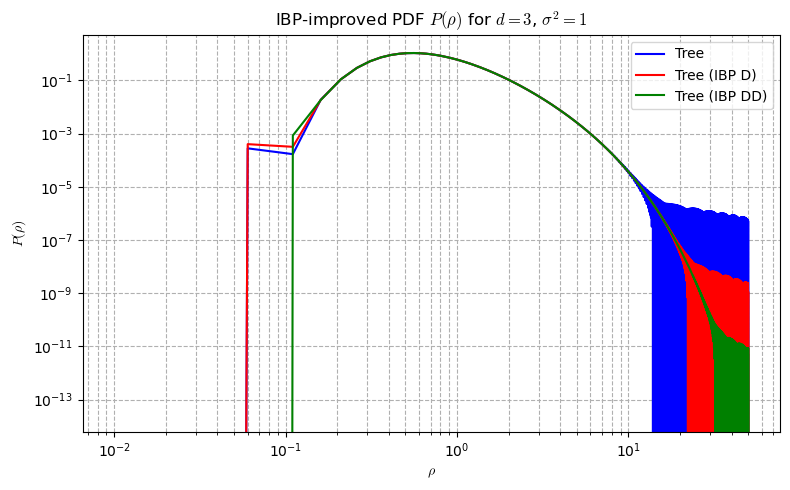

In [ ]:
plt.figure(figsize=(8,5))
plt.loglog(rho_vals, P_vals,    '-b', label='Tree')
plt.loglog(rho_vals, P_D_vals,  '-r', label='Tree (IBP D)')
plt.loglog(rho_vals, P_DD_vals, '-g', label='Tree (IBP DD)')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.title(r"IBP‐improved PDF $P(\rho)$ for $d=3$, $\sigma^2=1/2$")
plt.tight_layout()
plt.show()

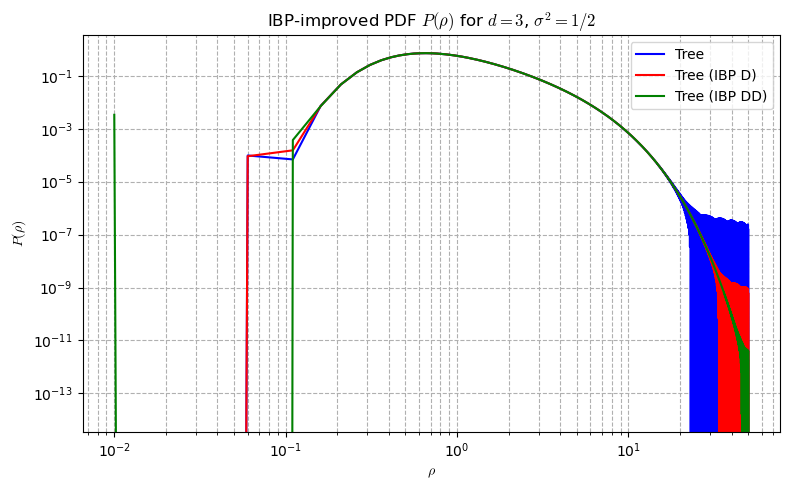

In [109]:
plt.figure(figsize=(8,5))
plt.loglog(rho_vals, P_NLO_vals,    '-b', label='Tree')
plt.loglog(rho_vals, P_D_NLO_vals,  '-r', label='Tree (IBP D)')
plt.loglog(rho_vals, P_DD_NLO_vals, '-g', label='Tree (IBP DD)')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.title(r"IBP‐improved PDF $P(\rho)$ for $d=3$, $\sigma^2=1/2$")
plt.tight_layout()
plt.show()

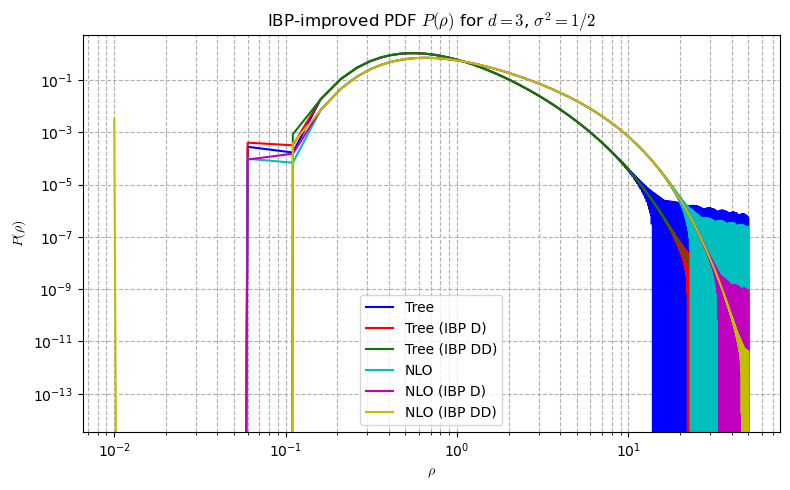

In [110]:
plt.figure(figsize=(8,5))
plt.loglog(rho_vals, P_vals,    '-b', label='Tree')
plt.loglog(rho_vals, P_D_vals,  '-r', label='Tree (IBP D)')
plt.loglog(rho_vals, P_DD_vals, '-g', label='Tree (IBP DD)')
plt.loglog(rho_vals, P_NLO_vals,    '-c', label='NLO')
plt.loglog(rho_vals, P_D_NLO_vals,  '-m', label='NLO (IBP D)')
plt.loglog(rho_vals, P_DD_NLO_vals, '-y', label='NLO (IBP DD)')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.title(r"IBP‐improved PDF $P(\rho)$ for $d=3$, $\sigma^2=1/2$")
plt.tight_layout()
plt.show()

In [122]:
# Helper to compute cumulants from a sampled PDF
def compute_cumulants(rho_vals, P_vals):
    drho = rho_vals[1] - rho_vals[0]
    
    # 2) Compute the mean: ∫ ρ·P(ρ) dρ
    mean = np.trapezoid(rho_vals * P_vals, rho_vals)

    # 3) Compute central moments
    diff = rho_vals/mean - 1
    m2 = np.trapezoid((diff**2) * P_vals, rho_vals)
    m3 = np.trapezoid((diff**3) * P_vals, rho_vals)
    m4 = np.trapezoid((diff**4) * P_vals, rho_vals)

    variance = float(m2)
    skewness = float(m3 / m2**2) if m2 > 0 else np.nan
    kurtosis = float((m4 - 3*m2**2)/ m2**3) if m2 > 0 else np.nan
    
    return {
        'mean': mean,
        'variance': variance,
        'skewness': skewness,
        'kurtosis': kurtosis
    }


In [123]:
# 4) Compute cumulants for the three PDFs
c_tree    = compute_cumulants(rho_vals,    P_vals)
c_IBP_D   = compute_cumulants(rho_vals,    P_D_vals)
c_IBP_DD  = compute_cumulants(rho_vals,    P_DD_vals)

# 5) Build a comparison DataFrame
df_cumulants = pd.DataFrame(
    [c_tree, c_IBP_D, c_IBP_DD],
    index=['Tree', 'Tree (IBP D)', 'Tree (IBP DD)']
)

# 6) Display the result
df_cumulants

mean  variance  skewness   kurtosis
Tree           1.000000  0.499988  3.997767  29.987040
Tree (IBP D)   1.000000  0.499938  4.001234  30.234055
Tree (IBP DD)  0.999997  0.499788  4.004298  30.264653

In [124]:
c_NLO    = compute_cumulants(rho_vals,    P_NLO_vals)
c_NLO_IBP_D   = compute_cumulants(rho_vals,    P_D_NLO_vals)
c_NLO_IBP_DD  = compute_cumulants(rho_vals,    P_DD_NLO_vals)
# 7) Build a comparison DataFrame for NLO
df_cumulants_NLO = pd.DataFrame(
    [c_NLO, c_NLO_IBP_D, c_NLO_IBP_DD],
    index=['NLO', 'NLO (IBP D)', 'NLO (IBP DD)']
)
# 8) Display the result
df_cumulants_NLO

mean  variance  skewness   kurtosis
NLO            1.5  0.696295  3.288485  17.882220
NLO (IBP D)    1.5  0.696277  3.288820  17.889532
NLO (IBP DD)   1.5  0.696365  3.287805  17.881908